# import & 関数定義

In [114]:
import os, sys, math, time, winsound, random, h5py, time, serial, itertools
import numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
# from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import model_from_json
from tensorflow.keras import layers
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import clear_output
import my_module as mm

os.makedirs("model_files", exist_ok=True)

In [2]:
def append(name):
    name_list.append(name)

In [164]:
def send(datalist, print_data=False):
    for i in range(len(datalist)):
        if datalist[i]<0:
            datalist[i]=abs(datalist[i])
            datalist[i]+=128
        else:
            datalist[i]=abs(datalist[i])
        if print_data:
            print(datalist[i])
    if serial:
        ser.write(bytes(datalist))

# パラメータ設定

In [159]:
weight_per_depth = 0.01 ### 重みの変化量に対するdepthの変化量(1/m)
depth_per_sec = 0.005### ソレノイド開放時間に対する砂山のdepth変化量(m/sec)
serial=False

In [160]:
if serial:
    ser = serial.Serial("COM9", 9600)

# 初期化

## NN構築

In [5]:
x_train, y_train, x_test, y_test = mm.make_dataset(1000, 5)

In [58]:
model_initial = keras.models.Sequential([
#   layers.Dense(3, activation='tanh'),
  layers.Dense(3, activation='tanh'),
  layers.Dense(2, activation='tanh'),
  layers.Dense(2, activation='tanh')
])
predictions = model_initial(np.array(x_train)[:1]).numpy()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

3/3 [==============================] - 0s 1ms/step - loss: 0.5354 - accuracy: 0.7361


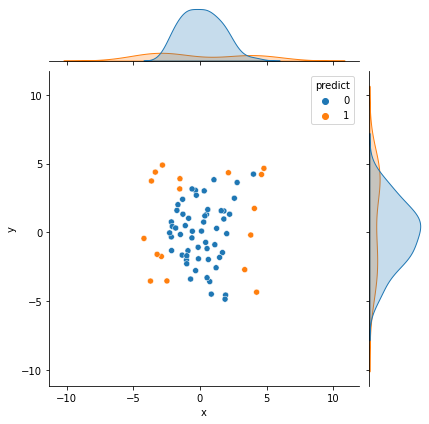

In [59]:
model_initial.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model_initial.fit(x_train, y_train, epochs=100, verbose=0)
model_initial.evaluate(x_test, y_test)
test_result_2=pd.concat([x_test, y_test, pd.Series(np.argmax(model_initial.predict(x_test, verbose=0), axis = 1), name="predict")], axis=1)
sns.jointplot(x='x', y='y', data=test_result_2, hue="predict", marker="o")

In [187]:
model_initial.save_weights("model_files/weight.hdf5")
model_initial.save_weights("model_files/weight_init.hdf5")
with open("model_files/model.json", 'w') as f:
    f.write(model_initial.to_json())

In [61]:
name_list=[]
data={}
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            data[name]=f[name][()]

In [62]:
parameter_count=0
for i in list(data):
    print(data[i], data[i].shape)
    if len(data[i].shape)>1:
        parameter_count+=data[i].shape[0]*data[i].shape[1]
    else:
        parameter_count+=data[i].shape[0]
print("parameter count:", parameter_count)

[ 0.7475028   0.69138515 -0.76085514] (3,)
[[ 0.61723924 -0.3434525   0.3902519 ]
 [-0.00594584 -0.13407955 -0.31977165]
 [-0.08661562 -0.26196694 -0.21573365]
 [-0.17486209 -0.13380603 -0.23029752]] (4, 3)
[-0.22114812 -0.38595432] (2,)
[[ 0.50566334  0.73974687]
 [-0.2584501   0.62808955]
 [-0.87328714 -0.40293834]] (3, 2)
[-0.2583094   0.28967893] (2,)
[[-0.2090663  -0.48072594]
 [ 1.4365573  -1.7289419 ]] (2, 2)
parameter count: 29


## Depth初期化

In [175]:
depth_init=pd.read_csv("model_files/depth_info.csv", header=None)
# depth_init.to_csv("model_files/depth_initial.csv", header=None, index=None)

In [176]:
depth_init

,0,1,2,3,4
0,0,0.000,0.000,0.000,0.000
1,0,0.000,0.000,0.264,0.241
2,0,0.000,0.000,0.000,0.430
3,0,0.000,0.000,0.421,2.358
4,0,0.477,0.412,1.917,1.996


# Loop部

## ちょっと学習


In [67]:
model.fit(x_train, y_train, epochs=1, verbose=0)

## 重み変化量を計算

### 前回の重みを読み込み

In [73]:
name_list=[]
weight_previous={}
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            weight_previous[name]=f[name][()]

### 学習後の重みを書き出し&読み込み

In [75]:
model.save_weights("model_files/weight.hdf5")

name_list=[]
weight_current={}
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            weight_current[name]=f[name][()]

In [115]:
weight_change

{'dense_21/dense_21/bias:0': array([ 0.00570107,  0.00236863, -0.00684506], dtype=float32),
 'dense_21/dense_21/kernel:0': array([[-0.00047338, -0.0005382 ,  0.00042751],
        [-0.00370957, -0.00015627, -0.00540981],
        [-0.00328165,  0.00054872, -0.00045714],
        [-0.00198852,  0.00077419, -0.00228177]], dtype=float32),
 'dense_22/dense_22/bias:0': array([-0.00116672, -0.00579292], dtype=float32),
 'dense_22/dense_22/kernel:0': array([[ 0.00450045,  0.00114387],
        [ 0.00036117,  0.00196034],
        [-0.00132251, -0.00349167]], dtype=float32),
 'dense_23/dense_23/bias:0': array([-0.00274867,  0.00508785], dtype=float32),
 'dense_23/dense_23/kernel:0': array([[ 0.00867769, -0.006962  ],
        [ 0.00961816, -0.00933552]], dtype=float32)}

In [142]:
weight_change={}
weight_change_list=[]
for item in weight_current:
    change=weight_current[item] - weight_previous[item]
    if len(change.shape)==1:
            list_item=change
    else:
        list_item=list(itertools.chain.from_iterable(change))
    weight_change_list.extend(list_item)
    weight_change[item] = weight_current[item] - weight_previous[item]

## Arduino用に数値を調整して送信

In [157]:
sec_list=weight_change_list.copy()
for i in range(len(weight_change_list)):
    sec_list[i]=int(weight_change_list[i]/weight_per_depth/depth_per_sec)
    if sec_list[i]>127:
        sec_list[i]=127
    if sec_list[i]<-127:
        sec_list[i]=-127
sec_list.append(128) # End

In [167]:
send(sec_list, print_data=False)

## depth.csvを読んで重みに変換

In [177]:
depth_current=pd.read_csv("model_files/depth_info.csv", header=None)

In [180]:
weight_matrix=(depth_current-depth_init)*weight_per_depth

In [186]:
new_weight_list=list(itertools.chain.from_iterable(weight_matrix.values.tolist()))

In [190]:
name_list=[]
stored_count=0
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):
            if len(data[name].shape)==1: # bias
                for x in range(data[name].shape[0]):
                    data[name][x]=new_weight_list[stored_count]
                    stored_count+=1
            elif len(data[name].shape)==2: # weight
                for x in range(data[name].shape[0]):
                    for y in range(data[name].shape[1]):
                        data[name][x][y]=new_weight_list[stored_count]
                        stored_count+=1
            else: #?
                raise UserWarning("length>3")
            f[name][()]=data[name]
#             print(f[name][()])

IndexError: list index out of range

### 書き換えた重みを確認

In [197]:
name_list=[]
weight_previous={}
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            weight_previous[name]=f[name][()]
weight_previous

{'dense_21/dense_21/bias:0': array([0., 0., 0.], dtype=float32),
 'dense_21/dense_21/kernel:0': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32),
 'dense_22/dense_22/bias:0': array([0., 0.], dtype=float32),
 'dense_22/dense_22/kernel:0': array([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 'dense_23/dense_23/bias:0': array([0., 0.], dtype=float32),
 'dense_23/dense_23/kernel:0': array([[-0.2090663 , -0.48072594],
        [ 1.4365573 , -1.7289419 ]], dtype=float32)}

## モデル再コンパイル&テストスコア出力

In [198]:
model=tf.keras.models.model_from_json(open("model_files/model.json", "r").read())
model.load_weights("model_files/weight.hdf5")
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

3/3 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5000


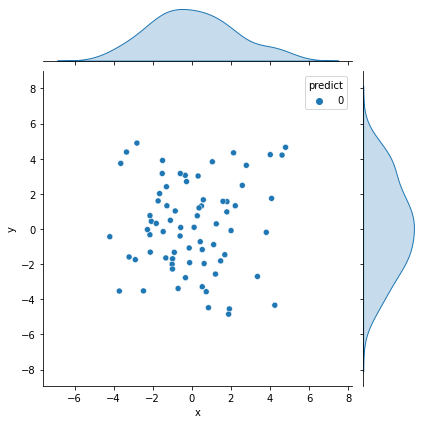

In [199]:
model.evaluate(x_test, y_test)
test_result=pd.concat([x_test, y_test, pd.Series(np.argmax(model.predict(x_test, verbose=0), axis = 1), name="predict")], axis=1)
sns.jointplot(x='x', y='y', data=test_result, hue="predict", marker="o")